<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Statistiques_descriptives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction** 

Dans cette partie, nous nous intéressons à visualiser les variables clés de notre base ainsi qu'établir quelques premières statistiques descriptives nous permettant d'intuiter l'influence des variables sur les critères de "succès" d'un film. On utilisera donc les bases *base.csv* et *base_keywords2.csv* nettoyées au préalable.

**Intégration continue**

In [1]:
from IPython.display import Image
try:
    im = Image("https://travis-ci.org/sdpython/ensae_teaching_cs.png")
except TimeoutError:
    im = None
im

Chargement des packages et de la base

In [2]:
!pip install --upgrade plotly
!pip install geopandas
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import zipfile
import tempfile
import datetime
import plotly.offline as py

     |████████████████████████████████| 13.2MB 339kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 972kB 9.0MB/s 
     |████████████████████████████████| 6.5MB 11.9MB/s 
     |████████████████████████████████| 14.8MB 161kB/s 


Création d'une palette.

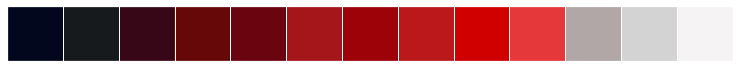

In [57]:
coolors = ["#03071e","#161a1d","#370617","#660708","#6a040f","#a4161a","#9d0208","#ba181b","#d00000","#e5383b","#b1a7a6","#d3d3d3","#f5f3f4"]

sns.set_palette(coolors)
sns.palplot(sns.color_palette())

On charge la base nettoyée avec le code du notebook *Scrapping et nettoyage*.

In [6]:
 df = pd.read_csv('https://raw.githubusercontent.com/marie-ganon/Projet-Python-S1/main/Bases_import%C3%A9es/base.csv')

In [7]:
df = df.drop(columns='Unnamed: 0')

In [8]:
print(' Taille de la base:',len(df),' lignes', '\n nombre de variables :', len(df.columns), 'colonnes')

 Taille de la base: 45417  lignes 
 nombre de variables : 24 colonnes


Dans ce notebook, nous allons réaliser des statistiques descriptives variées sur le contenu de notre base.

#### Sommaire

1. Quelques généralités sur les variables

2. Statistiques sur la variable *genres*
    - Genres présents au sein de la base
    - Genres des meilleurs films de la base
    - Boxplots par rapport au genre
    - Evolution de la production de films par genre

>  Variables quantitatives :
3. Statistiques sur le budget
4. Statistiques sur le revenu

>  Variables textuelles sur le contenu :
5. Statistiques sur les mots-clés
    - Récupération de la base et premier nuage de mots
    - Apparition des mots-clés en fonction du genre
    - Score et mots-clés
6. Statistiques sur le résumé
    - Détermination des mots fréquement utilisés dans les meilleurs films
7. Statistiques sur les tags

>   Autres variables d'intérêt :
8. Statistiques par producteur
  - Répartition géographique des films produits de la base
  - Production dans le temps
  - Evolution de la qualité des films dans le temps - Exemple de Disney et Paramount
  - Genres et producteurs 
  - Evolution du nombre de films par genre pour les plus gros producteurs - Exemple de Warner Bros et de la 20th Century Fox

9. Conclusions obtenues



# Quelques généralités

Avant de commencer, on peut essayer d'observer pour la base nettoyée la matrice des corrélations afin d'avoir une idée des liens entre les différentes variables quantitatives.

On peut noter qu'on s'attend à ce que *score_1* soit corrélé fortement à *vote_average* et *vote_count* par construction. 

In [61]:
corr = df.corr()
corr.style.background_gradient(cmap='Reds')

La matrice de corrélation ne nous apporte pas énormément d'information. On peut essayer de voir sur le subset complet du dataset. 

In [30]:
corr = df[['budget','score_1','popularity','revenue', 'runtime', 'vote_average', 'vote_count', 'collection',  'pc_id_count']].dropna().corr()
corr.style.background_gradient(cmap = 'Reds')

Notons que les variables *id*, *index*, *production_companies_id* ont peu de sens ici, il s'agit des identifiants reliés à la base, imdb et les producteurs respectivement. On les retire donc pour observer la matrice de corrélation. 
Il ressort des corrélations intéressantes entre *revenue*/*budget*, *budget*/*score_1*, *revenue*/*vote_count* et *revenue/score_1* . 




> Rappel variables :
- *genres* : genres correspondant au film
- *budget* : budget du film
- *popularity* : note attribuée par *The Movie Database* selon les notes, le nombre de votants, la date de sortie, et d'autres critères
- *revenue* : revenus générés par le film
- *runtime* : durée du film
- *vote_average* : moyenne de votes
- *vote_count* : nombre de votes
- *collection* : 0 si le film n'est pas dans une collection, 1 si oui (par ex. Toy Story 1 est dans la collection des films Toy Story)
- *score_1* : score construit à partir de *vote_count* et *vote_average*
- *production_companies_name* : nom du producteur
- *country_name* : pays de production
- *original language* : langue originale du film
- *pc_id_count* : nombre de films produits par un même producteur
- *overview* : résumé/synopsis
- *tagline* : tags associés à la recherche d'un film
- *release_date* : date de sortie du film
- *status* : statut du film (produit, annulé, en production etc.)



In [ ]:
df.columns

Index(['index', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'tagline', 'title', 'vote_average', 'vote_count',
       'collection', 'score_1', 'production_companies_name',
       'production_companies_id', 'pc_id_count', 'country_code',
       'country_name'],
      dtype='object')

# Statistiques sur la variable *genre*

## Genres présents au sein de la base

On créé un data frame comportant tous les genres de films présents dans la base.

In [11]:
l = []
for i in trange(len(df)):
    genre = str(df.genres[i]).split()
    for j in genre :
        l.append(j)

      
df_genre = pd.DataFrame(l, columns=['genre'])
# Traitement des 'nan' et des ''
df_genre = df_genre[df_genre.genre != 'nan']
df_genre.genre = df_genre.genre.str.replace(r',', '')
df_genre = df_genre[df_genre.genre != 'name']
liste_genre = list(df_genre.genre.unique())
df_genre = df_genre[df_genre.genre != liste_genre[20]]

In [12]:
df_genre.genre.unique()

array(['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Science', 'War', 'Mystery', 'Foreign', 'Music', 'Documentary',
       'Western', 'TV'], dtype=object)

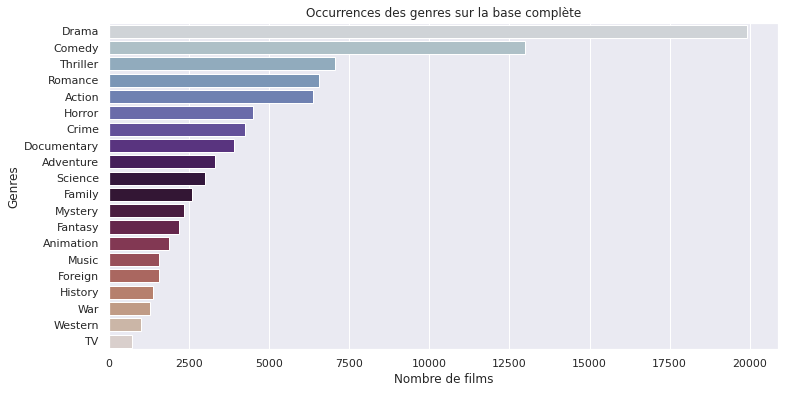

In [65]:
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index, palette='twilight')
plt.title('Occurrences des genres sur la base complète')
ax.set(xlabel='Nombre de films', ylabel='Genres')
sns.set(style='darkgrid')


Le graphique ci-dessus nous informe que les deux genres les plus représentés dans la base sont les comédies et les drames. Ce résultat est assez logique car ces types de films sont souvent donnés en complément d'un autre genre. A présent, étudions les films les mieux classés.

## Genres des meilleurs films de la base

In [ ]:
df.vote_count

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
45412       1.0
45413       3.0
45414       6.0
45415       0.0
45416       0.0
Name: vote_count, Length: 45417, dtype: float64

En regardant de plus près la variable *vote_count*, nous constatons que certains films comportent moins de 10 évaluations. Par conséquent, afin d'avoir une analyse plus fine de la base, nous allons étudier les genres les plus représentés sur les films les mieux notés selon le classement imdb, sous contrainte que suffisamment de personnes les aient évalués (plus de 100).

On construit donc "best movies" correspondant aux films ayant été notés par plus de 100 personnes et ayant une note supérieure à 7.0 qu'on compare à l'ensemble des films ayant été notés par plus de 100 personnes. 

In [17]:
df_classement =df[df.vote_count>100].sort_values(by='vote_average', ascending = False)     # on filtre sur les films qui ont été notés au moins 100 fois
df_best_movies = df_classement[df_classement.genres != '']    # on filtre sur les films pour lesquels le genre est renseigné
df_best_movies = df_best_movies[df.vote_average >= 7.0]      # on filtre sur les "meilleurs films" ie avec un score supérieur à 7
df_best_movies.reset_index(drop = True)
print('La base contient',len(df_best_movies),'films très bien notés (>= 7.0)')

La base contient 1759 films très bien notés (>= 7.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



On récupère deux dataframes, l'un pour les meilleurs genres, l'autre pour l'ensemble des genres.

In [18]:
l = []
for i in trange(len(df_best_movies)):
    if type(df_best_movies.genres.iloc[i]) == str :
        bm_genre = df_best_movies.genres.iloc[i].split()
        for i in bm_genre :
            l.append(i)
print(len(l))
df_bm_genre = pd.DataFrame(l, columns=['genre'])
df_bm_genre.genre = df_bm_genre.genre.str.replace(r',', '')
df_bm_genre['best_movies']=['Best movies' for i in range(len(df_bm_genre))]
df_genre['best_movies']=['All movies' for i in range(len(df_genre))]
# Traitement des ''
df_bm_genre = df_bm_genre[df_bm_genre.genre != 'name']
liste_genre = list(df_bm_genre.genre.unique())
df_bm_genre = df_bm_genre[df_bm_genre.genre != liste_genre[19]]


4372


On agrège pour comparer.

In [19]:
df_compare_genres = df_genre.append(df_bm_genre)

In [15]:
#fig, ax = plt.subplots(figsize=(12,6))
#sns.countplot(x='genre', hue='best_movies', data=df_compare_genres, order=df_genre.genre.value_counts(normalize=True).index)
#plt.xticks(rotation=45)
#plt.title('Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')
#ax.set(ylabel='Nombre de films', xlabel='Genres')

Un plot des observations des genres des films les mieux notés contre ceux de tous les films ne nous permet pas de conclure. On normalise donc tout cela pour faire apparaître la fréquence d'apparition des genres pour l'ensemble des films et pour les films les mieux notés. 

[Text(0, 0.5, 'Proportion'), Text(0.5, 0, 'Genres')]

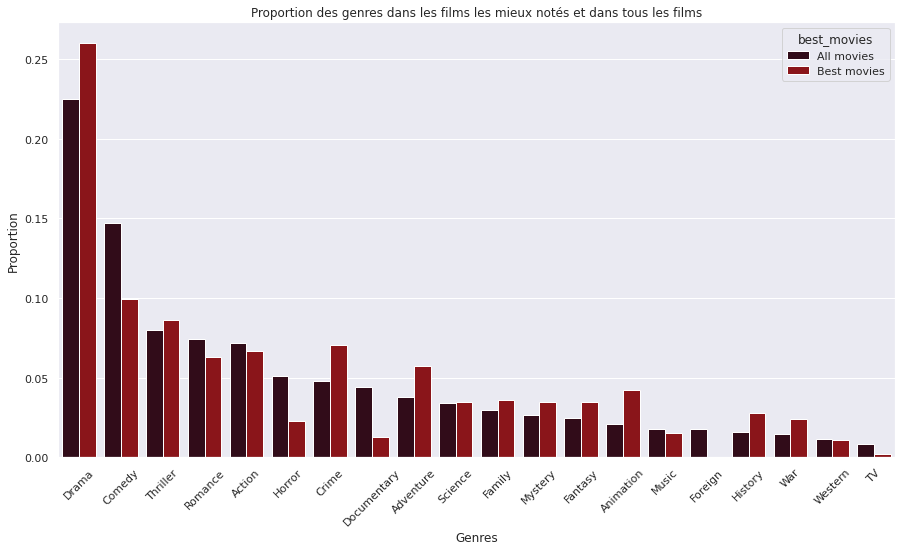

In [44]:
fig, ax = plt.subplots(figsize=(15,8))
x, y, hue = "genre", "proportion", "best_movies"
(df_compare_genres[x].groupby(df_compare_genres[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue, palette=[coolors[1], coolors[3]]))
sns.set(style='darkgrid')
plt.title('Proportion des genres dans les films les mieux notés et dans tous les films')
plt.xticks(rotation=45)
ax.set(ylabel='Proportion', xlabel='Genres')

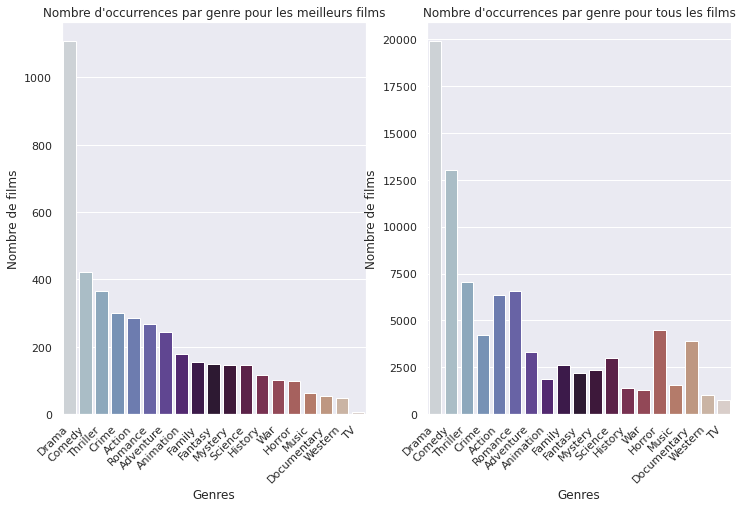

In [68]:
fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(12, 8))
sns.countplot(x = df_bm_genre.genre, order = df_bm_genre.genre.value_counts().index, ax = ax_1, palette='twilight')
plt.xticks(rotation=45)
sns.countplot(x = df_genre.genre, order = df_bm_genre.genre.value_counts().index,ax=ax_2, palette='twilight')

ax_1.title.set_text("Nombre d'occurrences par genre pour les meilleurs films")
ax_1.set(ylabel='Nombre de films', xlabel='Genres')

ax_2.title.set_text("Nombre d'occurrences par genre pour tous les films")
ax_2.set(ylabel='Nombre de films', xlabel='Genres')

fig.autofmt_xdate(rotation=45)

Nous remarquons que la tendance est sensiblement la même. En effet, avec environ plus de 18 000 films dramatiques, il est assez normal de trouver un bon nombre de films bien notés dans cet ensemble.

Toutefois, on constate que bien que certains genres de films soient très présents dans la base, ils peuvent apparaître moins souvent dans le classement des meilleurs films. 

En effet, alors que le genre Romance était le 3ème genre le plus présent, ici nous remarquons qu'il apparaît beaucoup plus loin dans le classement des genres les plus représentés dans les films les mieux notés (6e position). A l'inverse, le genre Crime est le 4 ème genre le plus représenté dans l'échantillon, et gagne alors 2 places par rapport à son classement dans l'échantillon initial.

## Boxplots par rapport au genre

[Text(0, 0.5, 'Genres'), Text(0.5, 0, 'Notes moyennes')]

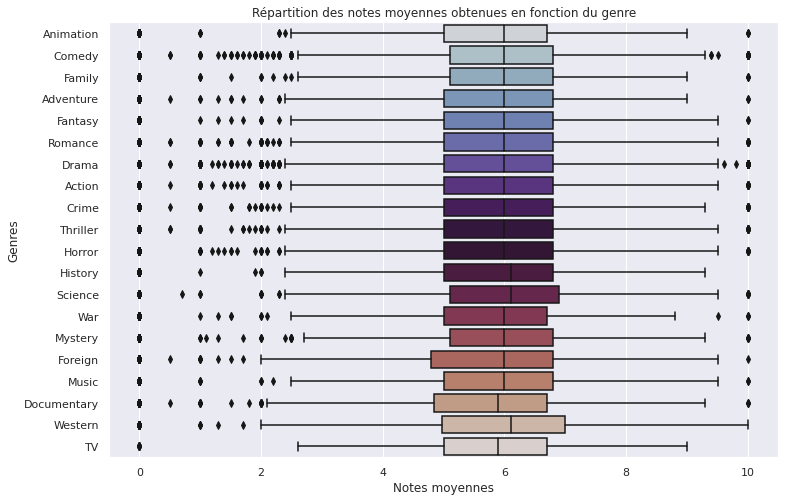

In [69]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=df_genre.genre, x = df.vote_average, palette='twilight')
ax.title.set_text('Répartition des notes moyennes obtenues en fonction du genre')
ax.set(ylabel='Genres', xlabel='Notes moyennes')

Globalement, la répartition des notes est la même pour chaque genre de film. Néanmoins, *vote_average* étant biaisé, on peut observer sur le *score_1* (succès critiques). On enlève les outliers pour pouvoir observer les données. 

[Text(0, 0.5, 'Genres'), Text(0.5, 0, 'Scores')]

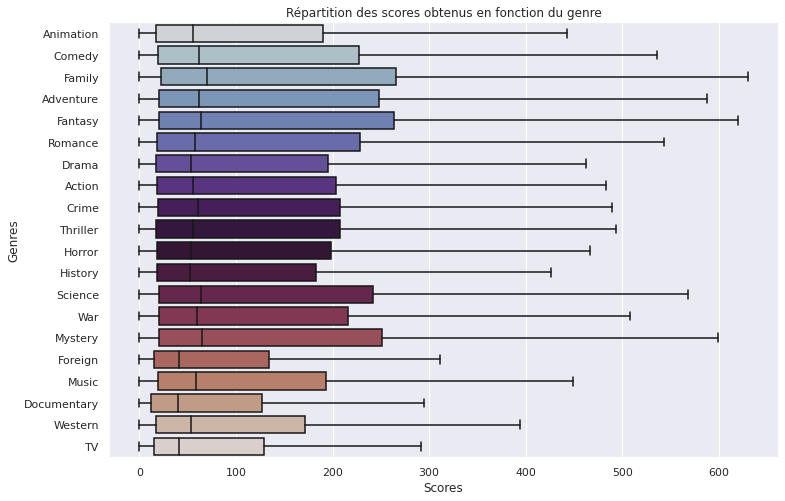

In [70]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=df_genre.genre, x = df.score_1, showfliers=False, palette='twilight')
ax.title.set_text('Répartition des scores obtenus en fonction du genre')
ax.set(ylabel='Genres', xlabel='Scores')

[Text(0, 0.5, 'Genres'), Text(0.5, 0, 'Popularité')]

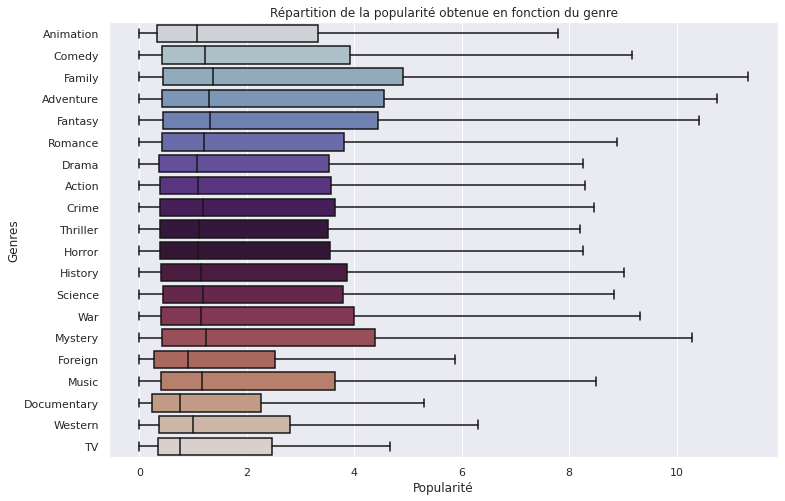

In [71]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(y=df_genre.genre, x = df.popularity, showfliers=False, palette='twilight')
ax.title.set_text('Répartition de la popularité obtenue en fonction du genre')
ax.set(ylabel='Genres', xlabel='Popularité')

La répartition change un petit peu : sans pouvoir déterminer clairement un genre pour lequel le score est plus élevé, on peut noter que les films des genres suivant bénéficient de scores plus faibles : *foreign*, *documentary* ou *tv*. 

## Evolution de la production de films par genre

Nous pouvons aussi nous demander si la production de films d'un certain genre a connu des certaines tendances au fil du temps. Pour simplifier, on va considérer le genre principal du film, c'est-à-dire la première catégorie de la variable *genre*.


In [168]:
df['main_genre']=df.genres.str.split(',').str.get(0)

In [169]:
df['main_genre'].dropna()

0        Animation
1        Adventure
2          Romance
3           Comedy
4           Comedy
           ...    
45410      Science
45411        Drama
45412        Drama
45413        Drama
45414       Action
Name: main_genre, Length: 42980, dtype: object

In [170]:
df['release_date']=pd.to_datetime(df['release_date'])
df['year']= df['release_date'].dt.year

On va créer des bases par genre, puis on compte le nombre de films par genre et par année.

In [171]:
def filtration_genre(df):
  dico_genres = dict()
  for movie_genre in tqdm(liste_genre):
    base_genre = df[df.genres == str(movie_genre)]
    base_genre['release_count'] = base_genre.groupby('year')['index'].transform('count')
    dico_genres[str(movie_genre)] = base_genre
  return dico_genres

In [173]:
dico_genres = filtration_genre(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Pour tracer ces graphiques, nous allons utiliser le package *plotly* qui nous permettra de naviguer sur les différentes courbes.

In [174]:
fig = go.Figure()
fig.layout.title.text = 'Evolution de la production de films par genre'
fig.layout.xaxis.title = 'Date de sortie'
fig.layout.yaxis.title = 'Nombre de films produits'

for keys in dico_genres.keys():
  dico_genres[str(keys)]= dico_genres[str(keys)].sort_values(by='year')
  fig.add_trace(go.Scatter(x=dico_genres[str(keys)].year, y=dico_genres[(str(keys))].release_count, name=str(keys)))
fig.show()

Concernant les genres, ce graphique ne permet pas de faire ressortir une tendance.
En revanche, on voit que la production totale de films a très fortement augmenté de 1980 à 2010. Ce constat est peut-être dû à plusieurs facteurs :
- Le développement du cinéma indien dès les années 1970
- La production massive de block-busters américains et de suites telles que les trilogies entre 1970 et 1990
- Une augmentation de la production de films d'animation grâce aux progrès du numérique dès les années 2000
- L'ajout dans la base de nombreux films indépendants obscurs grâce au développement d'internet depuis les années 2000


# Statistiques sur le budget

Une simple recherche internet nous informe que les budgets les plus petits dans la conception d'un film (appelés films "micro-budgets") s'élèvent à quelques milliers de dollars. On peut regarder la distribution des films micro-budgets.

In [ ]:
len(df.budget[df.budget == 0])/len(df.budget)*100

80.4500517427395

In [ ]:
df.budget[df.budget < 10000].describe()

count    36836.000000
mean         8.073977
std        201.173408
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9500.000000
Name: budget, dtype: float64

Ainsi, en moyenne, les films micro-budgets (budget inférieur à 10000 dollars) ont eu 8 dollars de budget.

In [ ]:
print('Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : \n', (len(df.budget[df.budget < 1000])/len(df.budget[df.budget < 10000]))*100,'%')

Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : 
 99.85340427842328 %


Au sein des microfilms, on compte 99.85% de films à budget inférieur à 1000 euros. Ce nombre est de fait assez suspect, on peut imaginer que la base contient des 0 pour les valeurs de budget inconnues ainsi que la plupart des nombres entre 0 et 1000 dollars de production sont des outliers dûs à des erreurs de saisies. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



[Text(0, 0.5, 'Densité'), Text(0.5, 0, 'Budget')]

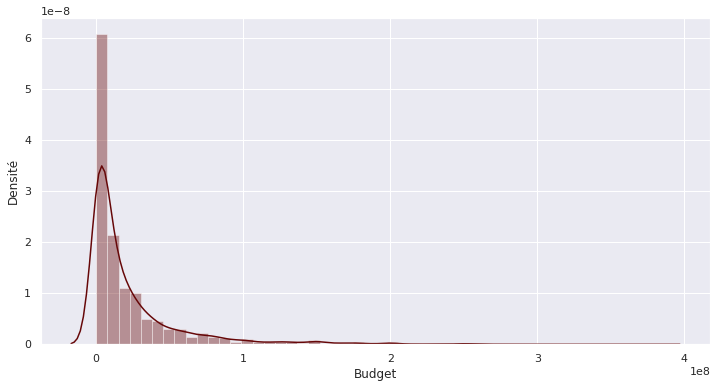

In [77]:
df_budget_ecrete = df.budget[df.budget > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_budget_ecrete, color=coolors[3])
ax.set(ylabel='Densité', xlabel='Budget')
#ax.set_xscale('log')
#ax.set_yscale('log')

L'information sur le budget paraît peu exploitable. Par conséquent, nous allons nous intéresser plus en détails aux revenus générés par le film.

# Statistiques sur les revenus

Etudions tout d'abord la proportion de films n'ayant généré aucun revenu:

In [ ]:
len(df.revenue[df.revenue == 0])/len(df.revenue)*100

83.70433978466212

Ainsi, plus de 83% des films de la base n'ont généré aucun revenu.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



[Text(0, 0.5, 'Densité'), Text(0.5, 0, 'Revenus générés')]

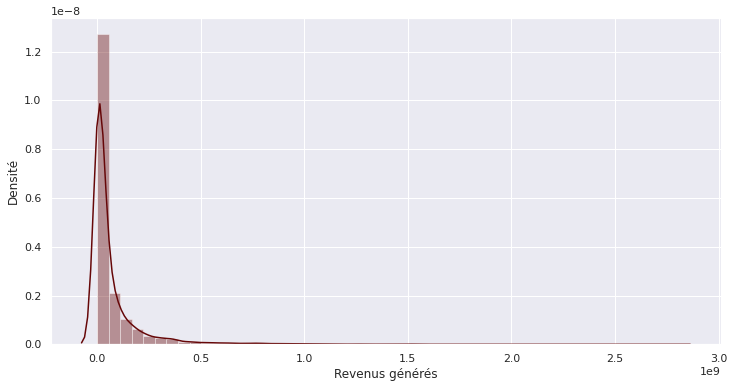

In [80]:
df_revenue_ecrete = df.revenue[df.revenue > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_revenue_ecrete, color=coolors[3])
ax.set(ylabel='Densité', xlabel='Revenus générés')
#ax.set_xscale('log')
#ax.set_yscale('log')

A travers ce graphique, on constate que la proportion de films à gros budget est très faible. De fait, nous ne pourrons pas non plus exploiter cette variable pour la modélisation. 

Comme *budget* et *revenue* sont mal renseignés, mais que ce sont des variables qui semblent être corrélées à la popularité/succès des films, on pourra se pencher dessus dans la partie de modélisation. 

# Statistiques sur les mots-clés

## Récupération de la base et premier nuage de mots

In [84]:
temp_dir = tempfile.mkdtemp()
with zipfile.ZipFile('base_keywords2.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')

df_2 = pd.read_csv('temp_dir/base_keywords2.csv', sep=';', encoding = 'utf-8', nrows=45466, low_memory = False)


A l'aide du package *wordcloud*, nous allons pouvoir créer des nuages de mots. Dans la fonction ci-dessous, nous avons anticipé pour supprimer des mots-clés qui n'étaient pas en rapport direct avec le scénario du film, par exemple le studio d'animation Ghibli ou le fait que le film soit culte.

In [ ]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = {'on', 'in', 'at', 'the', 'to', 'of', 'by', '_None', '_', 'NoNe', 'studio_ghibli', 'dc_comic', 'cult_film', 'neo_noir', 'black_comedy', 'dc_comics'} # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

Pour produire des nuages de mots qualitatifs, nous nous sommes rendu compte qu'il faut que l'algorithme puisse comprendre que chaque élément de *df_2.keywords[i]* correspond à un seul et unique mot-clé. Autrement, nous pourrions voir apparaître dans le nuage de mots à la fois 'new york' et 'york city'.

Par conséquent, nous allons traiter les données de manière astucieuse en utilisant plusieurs fois str.replace :

In [ ]:
print(df_2.keywords[0])

# On enlève les crochets et virgules et on les remplace par des tirets pour bien distinguer les mots-clés
df_2.keywords = df_2.keywords.str.replace(r'[^\w\s]', '-')
print(df_2.keywords[0])

# Les seuls espaces possibles se trouvent au sein d'un même mot-clé ou bien entre deux mots-clés distincts
df_2.keywords=df_2.keywords.str.replace(' ', '_')
print(df_2.keywords[0])

# On supprime les '-_-' qui ont été créés suite aux deux étapes précédentes
df_2.keywords = df_2.keywords.str.replace('-_-', '')
print(df_2.keywords[0])

# Désormais, les tirets sont la seule marque de ponctuation inutile
df_2.keywords = df_2.keywords.str.replace('-', ' ')
print(df_2.keywords[0])


['toy', 'rivalry', 'cowboy', 'cgi animation', 'claw crane', 'enemies become friends', 'toy comes to life', 'piggy bank', 'computer animation', 'dog', 'arcade game', 'two word title', 'birthday', "child's birthday", 'scene during opening credits', '1990s', 'dinosaur', 'suburb', "child's birthday party", 'birthday present', 'family relationships', 'jealousy', 'action figure', 'birthday party', 'anthropomorphism', 'brat', 'threat', 'magic 8 ball', 'directorial debut', 'toy dinosaur', 'falling out a window', 'toy soldier', 'first part', 'spaceman toy', 'friend', 'mr potato head', 'wilhelm scream', 'slinky dog', 'blockbuster', 'single mother', 'surprise ending', 'bo peep character', 'buzz lightyear character', 'woody character', 'poster', 'wallpaper', 'thunderstorm', 'talking toy', 'toy animal', 'gift', 'squeeze toy', 'bedroom', 'computer generated imagery', 'boy', 'toy story', 'anthropomorphic toy', "child's bedroom", 'scene before opening credits', "character's point of view camera shot",

Il ne reste plus qu'à concaténer tous les mots-clés pour pouvoir lancer la fonction nuage_de_mots précédente.

In [ ]:
mots_cles = ''
for i in trange(len(df_2)):
  mots_cles = mots_cles + str(df_2.keywords[i])

In [81]:
#mots_cles

Puis on affiche le nuage de mots correspondant à tous ces mots-clés.

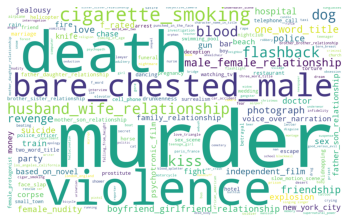

In [ ]:
nuage_de_mots(mots_cles)

Le nuage de mots ci-dessus retranscrit le nombre d'apparitions des mots-clés dans la base entière. Les trois mots qui correspondent au plus grand nombre de films sont 'violence', 'mort' et 'assassinat'. Cependant, si ces mots apparaissent souvent, c'est parce qu'ils se retrouvent dans de nombreuses catégories, telles que Thriller, Action, Horreur et Drame. Par conséquent, pour avoir plus de précisions sur la fréquence d'apparition des mots-clés, nous allons nous intéresser à ceux qui reviennent le plus au sein des meilleurs films d'un genre

## Apparition des mots-clés en fonction du genre

Nous disposons déjà de la liste des genres de films qui composent la base :

In [82]:
df_genre.genre.unique()
liste_genre = list(df_genre.genre.unique())

Nous pouvons désormais récupérer les mots-clés dans un dictionnaire qui a pour clés les différents genres.

In [85]:
dico_nuages = dict()
for movie_genre in tqdm(liste_genre):
  liste_movie_genre = ''
  for i in range (len(df_best_movies)):
    if str(movie_genre) in str(df_best_movies.genres.iloc[i]):
      keywords_movie = df_2.keywords[df_2.imdb_id == df_best_movies.imdb_id.iloc[i]]    # on récupère les mots-clés associés au film i du genre movie_genre 
      l = keywords_movie.to_string()                                                    # on doit convertir cette serie en string de la forme 'i   mots-clés'
      ll = l.split()
      if len(ll) > 1 :                                                                  # on vérifie que le film contient bien des mots-clés
        kw = ' '.join(ll[1:])                                                           # on convertit la liste précédemment créée en string
        liste_movie_genre += kw                                                         # on ajoute kw à la liste des mots-clés du genre
  dico_nuages[str(movie_genre)] = liste_movie_genre

Nuage de mots pour le genre Animation


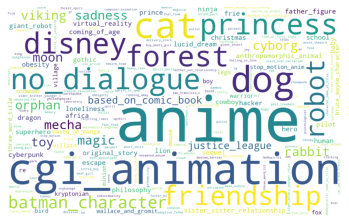

Nuage de mots pour le genre Comedy


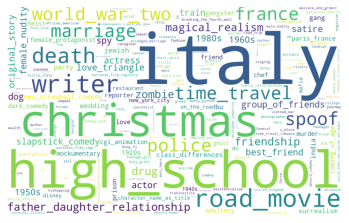

Nuage de mots pour le genre Family


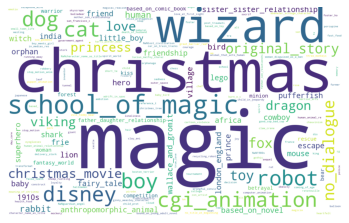

Nuage de mots pour le genre Adventure


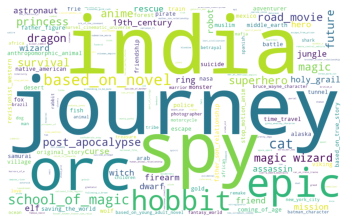

Nuage de mots pour le genre Fantasy


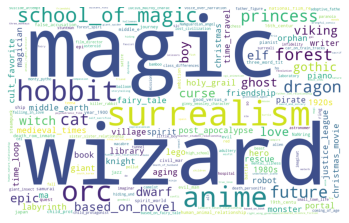

Nuage de mots pour le genre Romance


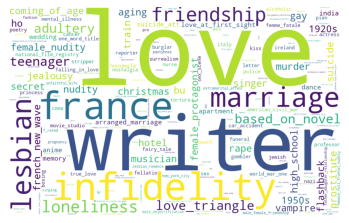

Nuage de mots pour le genre Drama


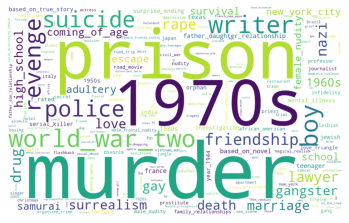

Nuage de mots pour le genre Action


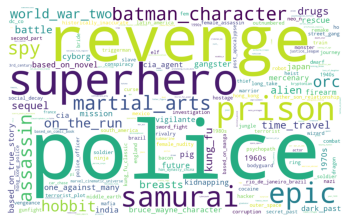

Nuage de mots pour le genre Crime


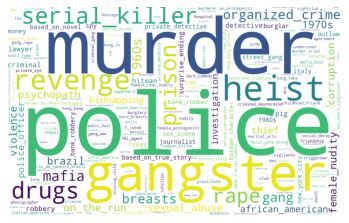

Nuage de mots pour le genre Thriller


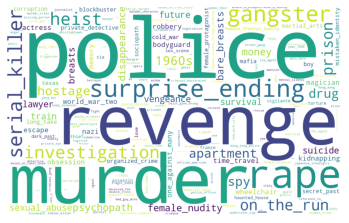

Nuage de mots pour le genre Horror


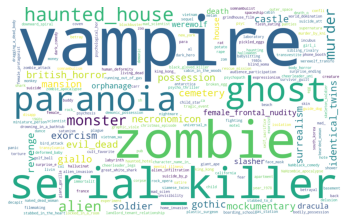

Nuage de mots pour le genre History


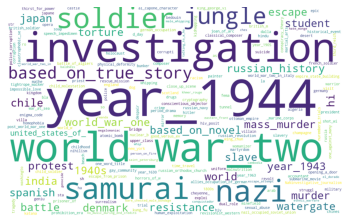

Nuage de mots pour le genre Science


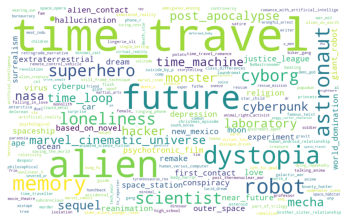

Nuage de mots pour le genre War


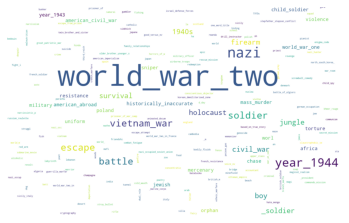

Nuage de mots pour le genre Mystery


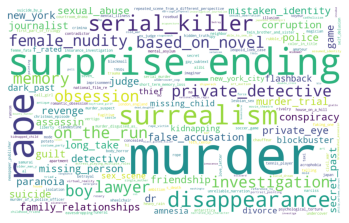

Nuage de mots pour le genre Music


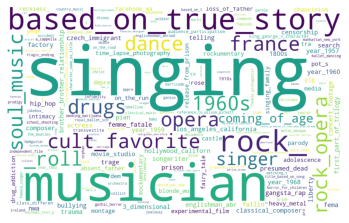

Nuage de mots pour le genre Documentary


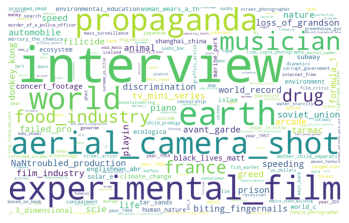

Nuage de mots pour le genre Western


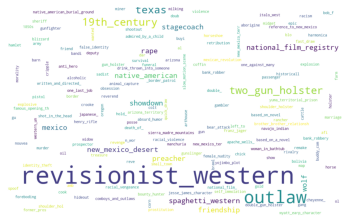

Nuage de mots pour le genre TV


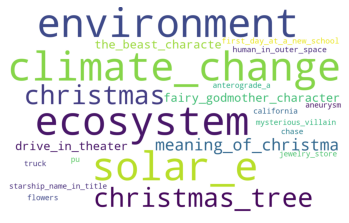

In [ ]:
for key in dico_nuages:
  if str(key) != 'Foreign':
    print('Nuage de mots pour le genre', key)
    nuage_de_mots(dico_nuages[str(key)])

Grâce à ces différents nuages de mots, nous pouvons déterminer quels mots-clés ressortent le plus dans les différents genres de films. Le résultat est assez cohérent. Néanmoins, pour les genres "Guerre" et "Western", les nuages de mots sont assez difficiles à lire dans la mesure où il y a très peu de mots-clés qui comportent beaucoup d'occurrences.

## Score et mots clés 



### Nuages de mots 
On considère comme "meilleurs films" les 200 meilleurs films selon *score_1* et *popularity* : on pourrait choisir comme meilleur score la variable qui donne un nuage de mots avec davantage de termes *clefs*.

In [ ]:
def nuage_de_mots_par_score(score):
    liste_film = df.sort_values(by=score, ascending=False)['original_title'].head(200).tolist()
    mots_cles = ''
    for i in trange(len(liste_film)):
        for movie in df_2.title :
            if str(liste_film[i]) in str(movie) :
                mots_cles = mots_cles + str(df_2.keywords[i])
    return nuage_de_mots(mots_cles), mots_cles
    

Nuage de mots selon popularity


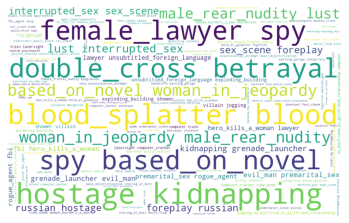

(None,
 '  toy rivalry cowboy cgi_animation claw_crane enemies_become_friends toy_comes_to_life piggy_bank computer_animation dog arcade_game two_word_title birthday child s_birthday scene_during_opening_credits 1990s dinosaur suburb child s_birthday_party birthday_present family_relationships jealousy action_figure birthday_party anthropomorphism brat threat magic_8_ball directorial_debut toy_dinosaur falling_out_a_window toy_soldier first_part spaceman_toy friend mr_potato_head wilhelm_scream slinky_dog blockbuster single_mother surprise_ending bo_peep_character buzz_lightyear_character woody_character poster wallpaper thunderstorm talking_toy toy_animal gift squeeze_toy bedroom computer_generated_imagery boy toy_story anthropomorphic_toy child s_bedroom scene_before_opening_credits character s_point_of_view_camera_shot famous_line first_of_series astronaut cowboy_doll dog_as_gift pet_as_gift mother_son_relationship reference_to_marie_antoinette commercial christmas_present toy_dog b

In [ ]:
print('Nuage de mots selon popularity')
nuage_de_mots_par_score('popularity')

Nuage de mots selon score_1


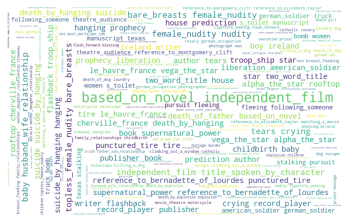

(None,
 '  toy rivalry cowboy cgi_animation claw_crane enemies_become_friends toy_comes_to_life piggy_bank computer_animation dog arcade_game two_word_title birthday child s_birthday scene_during_opening_credits 1990s dinosaur suburb child s_birthday_party birthday_present family_relationships jealousy action_figure birthday_party anthropomorphism brat threat magic_8_ball directorial_debut toy_dinosaur falling_out_a_window toy_soldier first_part spaceman_toy friend mr_potato_head wilhelm_scream slinky_dog blockbuster single_mother surprise_ending bo_peep_character buzz_lightyear_character woody_character poster wallpaper thunderstorm talking_toy toy_animal gift squeeze_toy bedroom computer_generated_imagery boy toy_story anthropomorphic_toy child s_bedroom scene_before_opening_credits character s_point_of_view_camera_shot famous_line first_of_series astronaut cowboy_doll dog_as_gift pet_as_gift mother_son_relationship reference_to_marie_antoinette commercial christmas_present toy_dog b

In [ ]:
print('Nuage de mots selon score_1')
nuage_de_mots_par_score('score_1')

On voit à travers les nuages de mots que les meilleurs films pour le score *score_1* et ceux pour *popularity* sont très différents. Il y a moins de mots de poids égal pour *popularity* avec des mots-clés dominants tels que : "kills woman", "rear nudity", "girlfriend relationship", "bloods platter", "daughter relationship" tandis que pour le *score_1*, le nuage est davantage homogène avec peu de mots clés ressortissant beaucoup. 

Les 200 meilleurs films selon le critère *popularity* semblent donc plus homogènes au niveau de leur contenu ce qui pourrait nous permettre de dégager des facteurs liés au "succès" parmi les mots clés. En revanche, le critère *score_1* nous affirme qu'il n'y a pas de mots clés particuliers à la réussite d'un film mais plutôt un scénario original... 

### LDA, scores et mots clés

La LDA ou Latent Dirichlet Application/Allocation est une méthode de NLP non supervisée de "topic modelling" c'est-à-dire une méthode probabiliste cherchant à mettre en valeur les structures thématiques cachées dans les documents textuels. On dispose en particulier d'outils qui vont nous permettre de visualiser dans l'espace les mots-clés.

On crée la fonction qui va nous faire la LDA. On va essayer de comparer selon les scores les topics retenus. 

On peut aussi essayer de visualiser l'homogénéité des *topics* existant pour chaque score (en prenant les 700 meilleurs films pour chaque score). 

In [86]:
df_score = pd.merge(df_2, df, how='inner', on='imdb_id').sort_values(by='score_1', ascending=False).head(700)

df_score = df_score.fillna('')

In [87]:
df_pop = pd.merge(df_2, df, how='inner', on='imdb_id').sort_values(by='popularity', ascending=False).head(700)
df_pop = df_pop.fillna('')

In [89]:
!pip install pyldavis

     |████████████████████████████████| 1.6MB 8.9MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=8e9c492429ed2d314de98e3244f4a0845b8d6359f3eb7522d1f26b50d76a6d5b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


def LDA_on_dataset(series, n_topic): #notre LDA prend en entrée le series.dataframe contenant l'information textuelle 
                                      #et le nombre de topic à modéliser
  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
  tfidf = tfidf_vectorizer.fit_transform(series)

  lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
  lda.fit(tfidf)
  LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
  
  tf_feature_names = tfidf_vectorizer.get_feature_names()

  return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)
  


In [91]:
print('Score : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_score['keywords'], 10)

Score : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.035947  0.000008       1        1  92.325181
5     -0.005617 -0.000848       2        1   0.852777
9     -0.001014  0.001222       3        1   0.852763
6      0.001250  0.000304       4        1   0.852759
3      0.005285 -0.000227       5        1   0.852755
1      0.005853 -0.000261       6        1   0.852754
7      0.006667 -0.000186       7        1   0.852753
8      0.007439 -0.000242       8        1   0.852753
0      0.007120 -0.000051       9        1   0.852753
4      0.008965  0.000281      10        1   0.852752, topic_info=          Term       Freq      Total Category  logprob  loglift
891        the  70.000000  70.000000  Default  30.0000  30.0000
909         to  61.000000  61.000000  Default  29.0000  29.0000
170  character  47.000000  47.000000  Default  28.0000  28.0000
627         of  49.000000  49.000000  Default  27.0000  27.0000
719  reference  47.000000  47.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
888  terrorist   0.072177   7.456238  Topic10  -6.7637   0.1268
783       ship   0.072520  10.424691  Topic10  -6.7590  -0.2036
674     police   0.074501  30.713750  Topic10  -6.7320  -1.2572
810      snake   0.070962   5.596060  Topic10  -6.7807   0.3968
325     father   0.070894  21.169052  Topic10  -6.7816  -0.9346

[757 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.917797    1980s
3         1  0.807580    2010s
7         1  0.858513    abuse
10        1  0.982449   action
14        1  0.969604   aerial
...     ...       ...      ...
988       1  0.992024    woman
991       1  0.928501    world
993       1  0.972405  writing
996       1  0.957810     york
999       1  0.851711   zombie

[373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 10, 7, 4, 2, 8, 9, 1, 5])

In [ ]:
#print('Popularity : \n')
#pyLDAvis.enable_notebook()
#LDA_on_dataset(df_pop['keywords'], 10)

On peut exécuter la cellule pour *popularity* mais les résultats sont sensiblement les mêmes sur les 700 premiers films de chaque score. En effet, on peut imaginer assez aisément que les 700 meilleurs films pour le premier score correspondra à peu près à celui pour le second. En variant sur le nombre de meilleurs films, on arrive sensiblement à la même chose. Cette méthode n'est pas très pertinente pour notre étude. Néanmoins elle pourra être utile pour dégager les topics dans d'autres données textuelles. 



Grâce aux statistiques sur les mots-clés, on détermine que *popularity* est un indicateur plus homogène de films ce qui nous permet de relier le succès d'un film à des aspects de son contenu/sa trame. Néanmoins, le score *score_1* a l'avantage de présenter des corrélations plus élevées avec des variables pertinentes telles que *budget* et *revenue*.  

# Statistiques sur le résumé

On s'intéresse de la même manière plutôt qu'aux mots-clés aux résumés des films. En effet, on peut se dire que les mots clés choisis ont pour but de faciliter la recherche du film et est davantage lié au genre des films qu'au contenu de l'action/de la trame.  

## Détermination des mots fréquemment utilisés dans les meilleurs films

In [92]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [93]:

df.overview = df.overview.fillna('')
df.overview.head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

On va retirer les stopwords dans les résumés afin de ne garder que les informations pertinentes. 

In [94]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['mr', 'it', 'ex', 'in', 'he', 'and', 'there', 'however', 'to', 'now', 'to', 'of', 'the', 'they', 'but', 'soon', 'film', 'that', 'who', 'of'])


df["overview"] = df["overview"].str.lower().str.split()

df['overview'] = df['overview'].apply(lambda x: [item for item in x if item not in stop])
df.overview.head()

0    [led, woody,, andy's, toys, live, happily, roo...
1    [siblings, judy, peter, discover, enchanted, b...
2    [family, wedding, reignites, ancient, feud, ne...
3    [cheated, on,, mistreated, stepped, on,, women...
4    [george, banks, recovered, daughter's, wedding...
Name: overview, dtype: object

En préparation de la LDA, on transforme la liste de mots en chaîne de caractères. 

In [95]:
for i in trange(len(df.overview)) : 
  str1 = ','.join(df.overview[i])
  df.overview[i]= str1 
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [96]:
df.overview.head()

0    led,woody,,andy's,toys,live,happily,room,andy'...
1    siblings,judy,peter,discover,enchanted,board,g...
2    family,wedding,reignites,ancient,feud,next-doo...
3    cheated,on,,mistreated,stepped,on,,women,holdi...
4    george,banks,recovered,daughter's,wedding,,rec...
Name: overview, dtype: object

On réalise une LDA (*Latent Dirichlet Allocation*) sur l'ensemble des films : en variant le nombre de topics voulus, on choisit la représentation la plus cohérente. 

In [97]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df['overview'], 8)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.108149 -0.031924       1        1  28.568288
3     -0.058774 -0.077353       2        1  16.002460
1     -0.010853 -0.058027       3        1  12.293230
4     -0.105677 -0.086725       4        1  12.122872
5     -0.032413  0.237215       5        1  11.515403
0      0.004496  0.209787       6        1   8.196598
2     -0.103585 -0.133118       7        1   6.720114
6      0.414954 -0.059854       8        1   4.581037, topic_info=            Term        Freq       Total Category  logprob  loglift
757       school  553.000000  553.000000  Default  30.0000  30.0000
958          war  535.000000  535.000000  Default  29.0000  29.0000
230  documentary  461.000000  461.000000  Default  28.0000  28.0000
402         high  405.000000  405.000000  Default  27.0000  27.0000
245        earth  300.000000  300.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
421        human  165.585463  296.866897   Topic8  -3.7567   2.4994
707         race  102.093996  189.390245   Topic8  -4.2403   2.4653
206       deadly   94.586884  186.022957   Topic8  -4.3167   2.4069
843      streets   71.291193  132.345053   Topic8  -4.5994   2.4646
188         crew   88.258676  195.708894   Topic8  -4.3859   2.2869

[437 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.302308       12
2         3  0.123671       12
2         4  0.563391       12
9         2  0.902806  accused
9         4  0.086570  accused
...     ...       ...      ...
997       7  0.057678    young
997       8  0.007083    young
998       1  0.271132  younger
998       4  0.646547  younger
998       7  0.072997  younger

[1291 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 2, 5, 6, 1, 3, 7])

Cette LDA nous dessine 5 topics se recoupant et 3 topics un peu plus éloignés.
On peut résumer chaque topic  :

1.   Comédies dramatiques, familiales, amoureuses, relations entre individus 
2.   Films policiers avec des gangsters, sur la criminalité, les marginaux
3.   Films sur la seconde guerre mondiale
4.   Documentaires (le topic est un peu plus décousu)
5.   Films adaptés de livres, focus sur un scénario original que sur des liens entre personnage dans le résumé
6.   Films policiers, surnaturels,  thrillers
7.    Films d'adolescents, sur le lycée, l'université...
8.   Topic un peu décousu, regroupe des termes sans grand rapport. 

Cela corrobore ce qu'on a vu sur la grosse représentation des différents genres. 




Qu'en est-il des résumés des *meilleurs films* ?

On reproduit les mêmes manipulations. 

In [98]:
#df_score['keywords']=df_score.keywords.apply(lambda x: [item for item in x if item not in stop])
df_top = df.sort_values(by='score_1', ascending=False).head(200)

In [99]:
df_top.overview.head()

15472    cobb,,skilled,thief,commits,corporate,espionag...
12477    batman,raises,stakes,war,crime.,help,lt.,jim,g...
22855    interstellar,chronicles,adventures,group,explo...
17806    unexpected,enemy,emerges,threatens,global,safe...
14544    22nd,century,,paraplegic,marine,dispatched,moo...
Name: overview, dtype: object

In [100]:
df_top["overview"] = df_top["overview"].str.lower().str.split()

df_top['overview'] = df_top['overview'].apply(lambda x: [item for item in x if item not in stop])

for i in df_top.overview.index : 
  str1 = ','.join(df_top.overview[i])
  df_top.overview[i]= str1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [101]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df_top['overview'], 5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.003623 -0.002263       1        1  21.996685
4      0.002643  0.001890       2        1  21.848970
3      0.002656 -0.002790       3        1  21.149274
2     -0.001701  0.003396       4        1  19.349996
1      0.000025 -0.000232       5        1  15.655074, topic_info=        Term      Freq     Total Category  logprob  loglift
365     game  0.000000  0.000000  Default  30.0000  30.0000
52      andy  0.000000  0.000000  Default  29.0000  29.0000
463     jedi  0.000000  0.000000  Default  28.0000  28.0000
370      get  0.000000  0.000000  Default  27.0000  27.0000
555      men  0.000000  0.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
652     plot  0.183747  0.990620   Topic5  -6.5404   0.1696
97    battle  0.179138  0.926169   Topic5  -6.5658   0.2115
718  revenge  0.173784  0.992492   Topic5  -6.5961   0.1120
529     made  0.171800  0.857592   Topic5  -6.6076   0.2466
566  mission  0.171919  0.997997   Topic5  -6.6069   0.0956

[241 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

Au sein des meilleurs films, il est plus difficile d'obtenir un topic exact dans la mesure où il y a peu de termes qui vont être récurrents. On voit en effet qu'on peut reconnaître certains films précis au travers des top words : les prénoms des protagonistes d'Harry Potter, du Seigneur des anneaux, de Star wars etc. Les termes apparaissant le plus sont ceux de synopsis de films à plusieurs volets par ailleurs.

 On remarque néanmoins qu'il n'y a pas la surreprésentation des topics s'apparentant aux comédies, drames et romances. 

On peut en conclure qu'il est difficile de déterminer une recette "succès" pour un très bon film, les scénarii étant d'autant plus variés au sein de ce sous groupe. 

# Statistiques sur les tags

On peut enfin faire la même manipulation pour les tags, c'est-à-dire le slogan publicitaire qui caractérise le film.

In [102]:
df.tagline = df.tagline.fillna(' ')

In [103]:
stop = stopwords.words('english')
stop.extend(['mr', 'it', 'ex', 'in', 'he', 'and', 'there', 'however', 'to', 'now', 'to', 'of', 'the', 'they', 'but', 'soon', 'film', 'that', 'who', 'of'])

df.tagline = df.tagline.fillna('')

df["tagline"] = df["tagline"].str.lower().str.split()
df['tagline']=df.tagline.apply(lambda x: [item for item in x if item not in stop])

df.tagline.head()


0                                                   []
1                   [roll, dice, unleash, excitement!]
2    [still, yelling., still, fighting., still, rea...
3    [friends, people, let, yourself..., never, let...
4      [world, back, normal..., he's, surprise, life!]
Name: tagline, dtype: object

In [104]:

for i in trange(len(df.tagline)) : 
  str1 = ','.join(df.tagline[i])
  df.tagline[i]= str1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
df.tagline.head()

0                                                     
1                        roll,dice,unleash,excitement!
2     still,yelling.,still,fighting.,still,ready,love.
3    friends,people,let,yourself...,never,let,forge...
4             world,back,normal...,he's,surprise,life!
Name: tagline, dtype: object

In [ ]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df['tagline'], 10)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.162307 -0.136184       1        1  12.359974
9     -0.207808 -0.105748       2        1  11.475790
3     -0.030417  0.234647       3        1  10.898139
2      0.016588  0.251995       4        1  10.564565
7     -0.157756 -0.109466       5        1   9.712405
4      0.074473 -0.086056       6        1   9.668484
5     -0.090365  0.138514       7        1   9.541132
6      0.237568 -0.157951       8        1   9.287371
1      0.231766  0.004774       9        1   8.420855
0      0.088258 -0.034526      10        1   8.071284, topic_info=       Term        Freq       Total Category  logprob  loglift
600     new  217.000000  217.000000  Default  30.0000  30.0000
819   story  360.000000  360.000000  Default  29.0000  29.0000
599   never  252.000000  252.000000  Default  28.0000  28.0000
155  comedy  154.000000  154.000000  Default  27.0000  27.0000
857  terror  136.000000  136.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
469    know   85.247865  115.133465  Topic10  -3.4847   2.2163
659   place   56.440435   74.115865  Topic10  -3.8971   2.2444
993   years   38.669202   72.749474  Topic10  -4.2753   1.8849
985   world   26.990253  261.900425  Topic10  -4.6348   0.2444
819   story   24.950628  360.391748  Topic10  -4.7134  -0.1534

[397 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         4  0.980444        000
11        9  0.987987     action
13        1  0.115405  adventure
13        2  0.613090  adventure
13        3  0.108192  adventure
...     ...       ...        ...
993       2  0.206187      years
993      10  0.536086      years
996       2  0.986757        you
997       4  0.722396      young
997       7  0.257999      young

[432 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 4, 3, 8, 5, 6, 7, 2, 1])

Etonnament, la LDA sur les tags ne ressemble pas du tout à celle que l'on a effectuée sur les mots-clés. On retrouve alors 10 topics, dispersés autrement dans le plan. Cependant, il est assez difficile de caractériser tous ces topics.

# Statistiques par compagnie de production de films pour les producteurs les plus prolifiques

Il y a plusieurs aspects que l'on peut étudier sur les compagnies de production : 
- On peut observer les compagnies de production par pays
- On veut essayer de se pencher sur les plus grands studios/producteurs de films et observer leur évolution dans le temps. 

*production_companies_name* donne le nom des compagnies de production, *pc_id_count* donne le nombre de films produits par la compagnie de production correspondante, *production_companies_id* est un id unique pour chaque compagnie de production. 

## Répartition géographique des films produits

On récupère la géométrie des pays :

In [106]:
world = gpd.read_file(r"https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json")

In [107]:
world.head()

id                  name                                           geometry
0  AFG           Afghanistan  POLYGON ((61.21082 35.65007, 62.23065 35.27066...
1  AGO                Angola  MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...
2  ALB               Albania  POLYGON ((20.59025 41.85540, 20.46317 41.51509...
3  ARE  United Arab Emirates  POLYGON ((51.57952 24.24550, 51.75744 24.29407...
4  ARG             Argentina  MULTIPOLYGON (((-65.50000 -55.20000, -66.45000...

On va faire une jointure des deux datasets. 

In [108]:
country_nb = df.groupby('country_name', as_index=False)['id'].count()

In [109]:
country_nb.country_name = country_nb.country_name.str.lstrip( )
#pd.unique(country_nb.country_name)

In [110]:
result = pd.merge(country_nb, world, left_on='country_name', right_on='name')
result['n_count'] = result['id_x']
result = result.drop(columns = 'id_x')

result.n_count = result.n_count.div(sum(result.n_count)*100)

In [111]:
gpd_map = gpd.GeoDataFrame(result)
gpd_map.n_count = gpd_map.n_count.fillna('0')

In [112]:
help(gpd_map.plot)

Help on method plot in module geopandas.geodataframe:

plot(*args, **kwargs) method of geopandas.geodataframe.GeoDataFrame instance
    Plot a GeoDataFrame.
    
    Generate a plot of a GeoDataFrame with matplotlib.  If a
    column is specified, the plot coloring will be based on values
    in that column.
    
    Parameters
    ----------
    df : GeoDataFrame
        The GeoDataFrame to be plotted.  Currently Polygon,
        MultiPolygon, LineString, MultiLineString and Point
        geometries can be plotted.
    column : str, np.array, pd.Series (default None)
        The name of the dataframe column, np.array, or pd.Series to be plotted.
        If np.array or pd.Series are used then it must have same length as
        dataframe. Values are used to color the plot. Ignored if `color` is
        also set.
    cmap : str (default None)
        The name of a colormap recognized by matplotlib.
    color : str (default None)
        If specified, all objects will be colored uniforml

Text(0.5, 1.0, 'Provenance des films de la base (en pourcentage)')

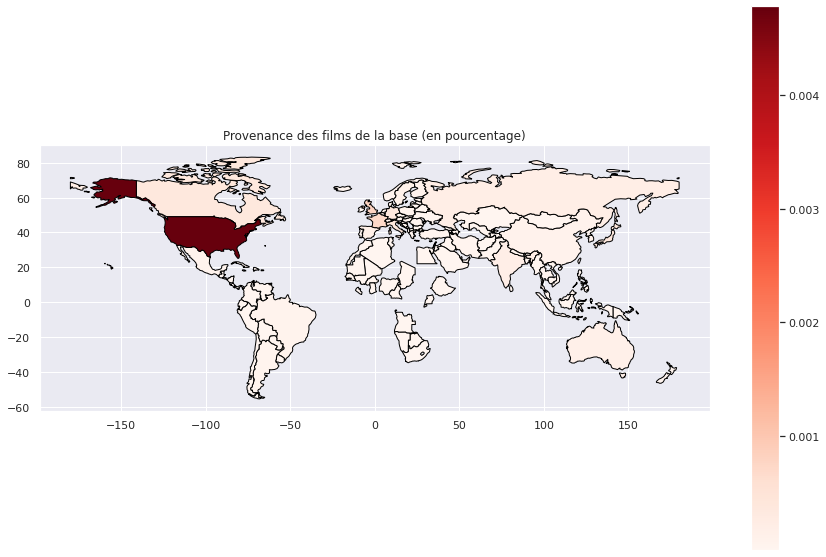

In [114]:
gpd_map.plot(column='n_count', legend = True, figsize=(15,10), cmap='Reds', edgecolor='black')
plt.title('Provenance des films de la base (en pourcentage)')

La base de *the Movie Database* contient une majorité de films américains. On voit que l'Inde ne se détache pas de la carte alors que l'industrie du film indienne est plus prolifique (en quantité) que Hollywood. La base renseigne en fait des films internationaux d'où la prédominance américaine. 


## Production de films dans le temps

In [120]:
df_prod = df[df.pc_id_count > 200]
print('Pour des producteurs au dessus de 200 films \n', 'Nombre de films: \n' , len(df_prod), ' \n Nombre de producteurs: \n', len(pd.unique(df_prod.production_companies_name)))

Pour des producteurs au dessus de 200 films 
 Nombre de films: 
 6053  
 Nombre de producteurs: 
 11


Il y a 6031 films produits par des producteurs ayant faits plus de 200 films.  

On va désormais s'intéresser à l'évolution du nombre de films produits par an pour toutes les grandes compagnies de production. On compte tout d'abord le nombre de films produits par an :

In [126]:
df_prod['release_count'] = df_prod.groupby('year')['index'].transform('count')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Puis on trace le graphique associé :

Text(0.5, 1.0, 'Evolution du nombre total de films produits au cours du temps par des compagnies ayant réalisé plus de 200 films')

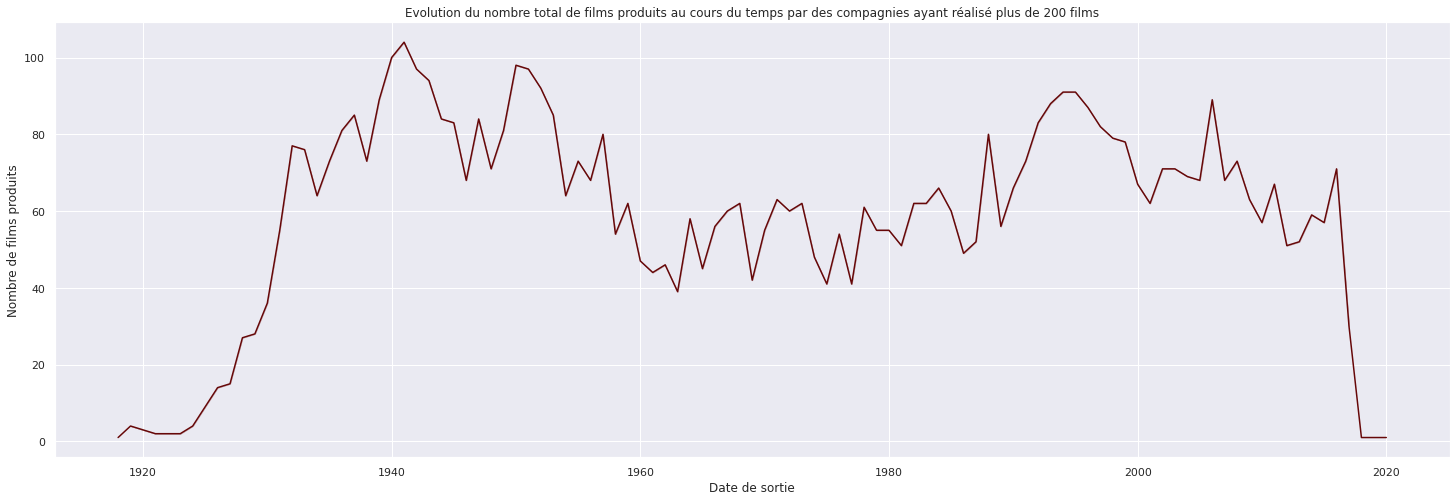

In [129]:
fig, ax = plt.subplots(figsize=(25,8))
sns.lineplot(x="year", y="release_count", data=df_prod, color=coolors[3])
ax.set(ylabel='Nombre de films produits', xlabel='Date de sortie')
plt.title("Evolution du nombre total de films produits au cours du temps par des compagnies ayant réalisé plus de 200 films")

On peut obtenir plus de précisions en traçant différentes courbes, relatives aux différentes compagnies de production concernées :

In [130]:
liste_pc = pd.unique(df_prod.production_companies_name)
print('Les plus grands producteurs :\n ', liste_pc)

Les plus grands producteurs :
  [' Warner Bros' ' Twentieth Century Fox Film Corporation'
 ' Paramount Pictures' ' Walt Disney Pictures' ' Universal Pictures'
 ' United Artists' ' Columbia Pictures' ' Columbia Pictures Corporation'
 ' New Line Cinema' ' MetroGoldwynMayer MGM' ' RKO Radio Pictures']


In [131]:
dico_prod = dict()
for prod in tqdm(liste_pc):
  base_pc = df_prod[df_prod.production_companies_name == str(prod)]
  base_pc['release_count'] = base_pc.groupby('year')['index'].transform('count')
  dico_prod[str(prod)] = base_pc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Pour plus de lisibilité, nous allons générér plusieurs graphiques.

In [132]:
def plot_prod(dico_prod, liste_prod):
  fig = go.Figure()
  fig.layout.title.text = 'Evolution du nombre de films produits en fonction de la compagnie de production' 
  fig.layout.xaxis.title = 'Date de sortie'
  fig.layout.yaxis.title = 'Nombre de films produits'
  
  for keys in liste_prod:
    dico_prod[str(keys)] = dico_prod[str(keys)].sort_values(by='year')
    fig.add_trace(go.Scatter(x=dico_prod[str(keys)].year, y=dico_prod[str(keys)].release_count, name=str(keys)))
  fig.show()

In [ ]:
plot_prod(dico_prod, liste_pc[:4])

Tandis que le nombre de films produits par  la 20th Century Fox et la Warner diminue depuis 2006, Disney accroît sa production depuis les années 1990. Cela est peut-être dû aux rachats d'autres compagnies, telles que Pixar, Lucasfilm et Marvel Studios. Paramount reste relativement stable dans sa production de film.

In [133]:
plot_prod(dico_prod, liste_pc[4:8])

On constate que la production de films s'est arrêtée en 2007 pour Columbia Pictures Corporation, sûrement à cause de la fusion avec Columbia Pictures. De même, United Artists ne produit plus rien après 2010 en raison de son rachat par Metro Goldwyn Mayer.

En ce qui concerne les tendances, Universal Studio a toujours été très prolifique, sauf entre 1945 et 1960.

In [ ]:
plot_prod(dico_prod, liste_pc[8:])

Sur ce graphique, on observe que la RKO a disparu en 1957, tandis que New Line Cinema, compagnie assez récente, s'est surtout développée entre 1990 et 2010. Quant à Metro Goldwyn Mayer, si la compagnie a été très prolifique jusqu'aux années 1970, sa production a drastiquement chuté dès 1974.

## Evolution de la qualité des films dans le temps - Disney et Paramount

Dans cette partie, nous allons nous demander comment a évolué la qualité des films dans le temps pour deux grandes compagnies de production : Walt Disney Pictures et Paramount Picture. Nous allons assimiler le succès d'un film à la valeur de *score_1* qui lui est associée.

Tout d'abord, créeons les deux data frames correspondant aux succès de Walt Disney Pictures et de Paramount Pictures

In [134]:
disney_evol = df_prod[df_prod.production_companies_name == ' Walt Disney Pictures']
disney_evol = disney_evol.reset_index()

paramount_evol = df_prod[df_prod.production_companies_name == ' Paramount Pictures']
paramount_evol = paramount_evol.reset_index()

Nous ne conserverons que les années de sortie des films pour observer la qualité des films dans le temps.

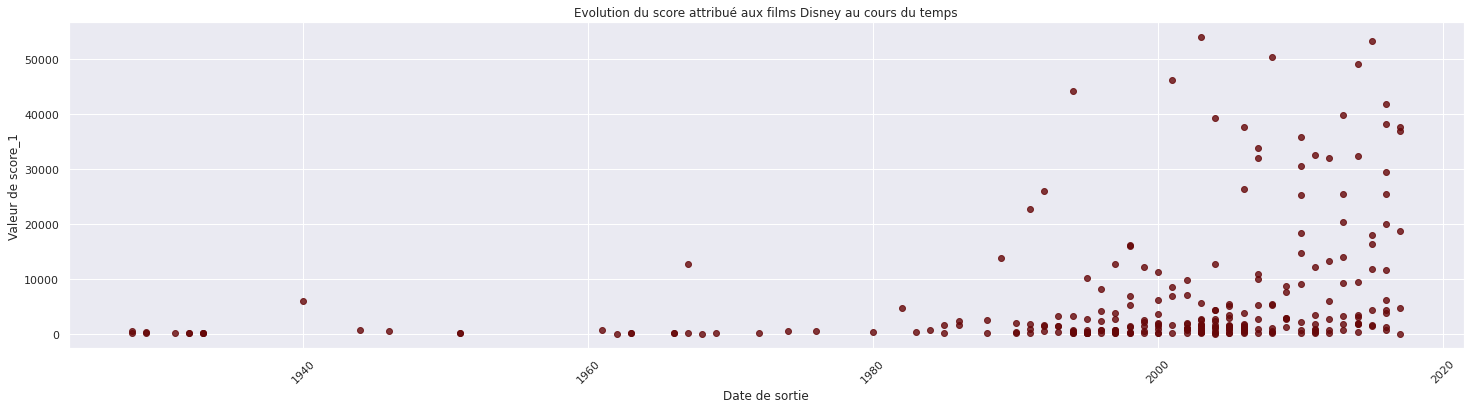

In [136]:
fig, ax = plt.subplots(figsize=(25,6))
sns.regplot(x=disney_evol.release_date.dt.year, y=disney_evol.score_1, fit_reg=False, color=coolors[3])
ax.set(ylabel='Valeur de score_1', xlabel='Date de sortie')
plt.xticks(rotation = 45)
plt.title('Evolution du score attribué aux films Disney au cours du temps')
plt.show()

Ce scatterplot du score selon la date de sortie du film ne dessine pas de tendance particulière. 

On peut essayer d'observer la moyenne par date de sortie et sur le même graphique le nombre de sorties par date. 

In [137]:
disney_evol['release_year']=disney_evol.release_date.dt.year
paramount_evol['release_year']=paramount_evol.release_date.dt.year

In [138]:
disney_evol_mean = disney_evol.groupby('release_year').score_1.mean()
disney_evol_count = disney_evol.groupby('release_year').index.count()

pm_evol_mean = paramount_evol.groupby('release_year').score_1.mean()
pm_evol_count = paramount_evol.groupby('release_year').index.count()


On normalise en pourcentage les notes : on veut avoir les notes moyennes par année.

In [139]:
disney_evol_2 = pd.merge(disney_evol_mean, disney_evol_count, left_on = disney_evol_mean.index, right_on=disney_evol_count.index)
disney_evol_2 = disney_evol_2.rename(columns={'key_0':'release_date', 'index':'n_count'})

pm_evol_2 = pd.merge(pm_evol_mean, pm_evol_count, left_on = pm_evol_mean.index, right_on=pm_evol_count.index)
pm_evol_2 = pm_evol_2.rename(columns={'key_0':'release_date', 'index':'n_count'})

disney_evol_2.head()

release_date     score_1  n_count
0          1928  330.800000        2
1          1929  135.550000        2
2          1931   28.800000        1
3          1932   84.200000        2
4          1933   36.666667        3

In [140]:
disney_evol_2['avg_score_per_year']=disney_evol_2['score_1'].div(disney_evol_2.n_count)

pm_evol_2['avg_score_per_year']=pm_evol_2['score_1'].div(pm_evol_2.n_count)

In [141]:
disney_evol_2.release_date = disney_evol_2.release_date .astype('float')

pm_evol_2.release_date = pm_evol_2.release_date .astype('float')

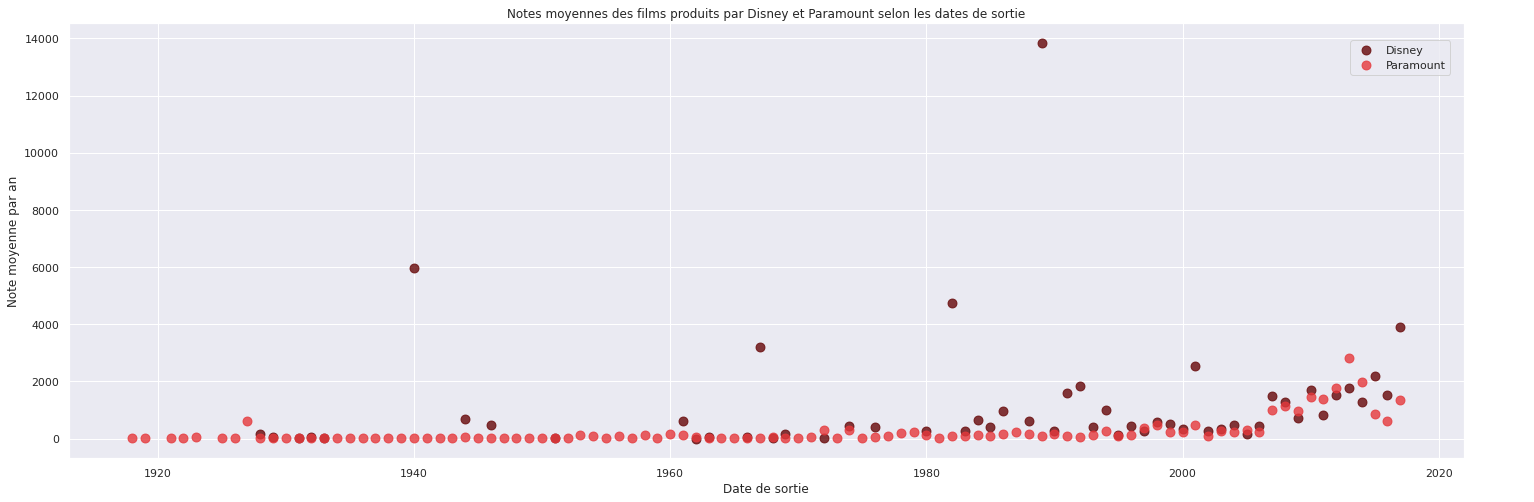

In [150]:
fig, ax = plt.subplots(figsize=(25,8))
sns.regplot(x=disney_evol_2.release_date, y=disney_evol_2.avg_score_per_year, fit_reg=False, scatter_kws={"s": 80}, color=coolors[3])
sns.regplot(x=pm_evol_2.release_date, y=pm_evol_2.avg_score_per_year, fit_reg=False, scatter_kws={"s": 80}, color=coolors[9])

plt.title('Notes moyennes des films produits par Disney et Paramount selon les dates de sortie')
fig.legend(labels= ['Disney', 'Paramount'], loc = (0.88, 0.85))
ax.set(ylabel='Note moyenne par an', xlabel='Date de sortie')
plt.show()



Le graphique est mal calibré à cause d'une année outlier correspondant sans doute à une année avec un énorme succès pour Disney. 

In [145]:
disney_evol_2[disney_evol_2.avg_score_per_year == max(disney_evol_2.avg_score_per_year)]

release_date  score_1  n_count  avg_score_per_year
26        1989.0  13831.2        1             13831.2

On va regarder le film correspondant à un tel score.

In [146]:
df[df.score_1==13831.2].title

1971    The Little Mermaid
Name: title, dtype: object

Il s'agit de la *Petite Sirène*.

On va observer ce qu'il en est des valeurs lorsqu'on enlève les 5% max. 

In [147]:
df_de = disney_evol_2.sort_values(by='avg_score_per_year').head(int(len(disney_evol_2)*0.95))

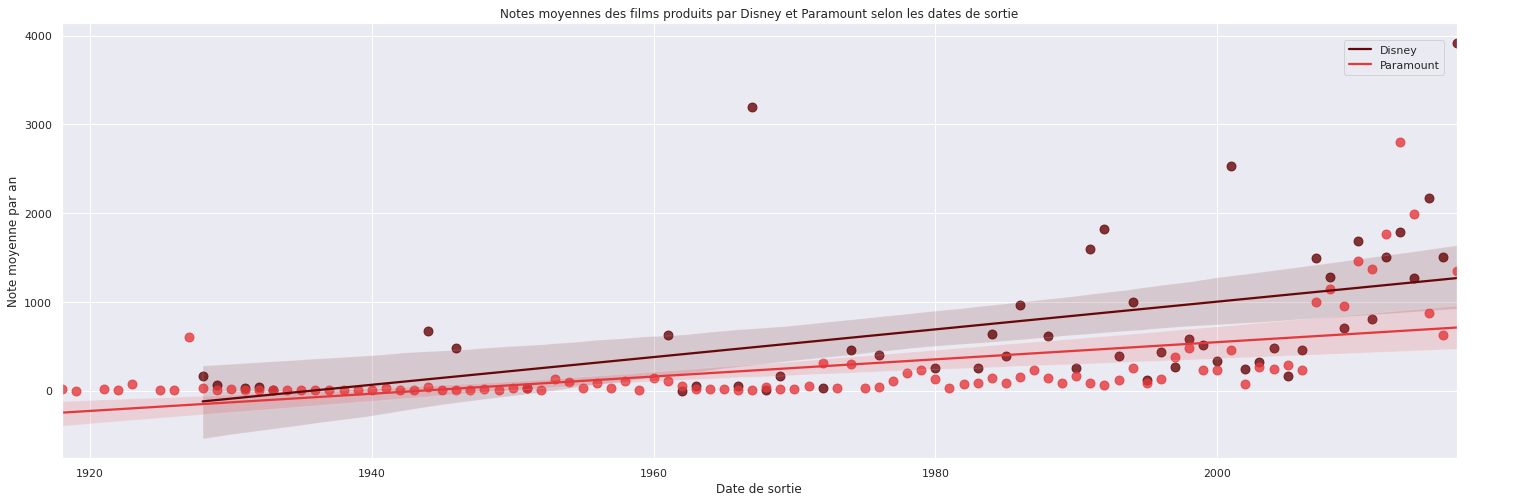

In [149]:
fig, ax = plt.subplots(figsize=(25,8))
sns.regplot(x=df_de.release_date, y=df_de.avg_score_per_year, fit_reg=True, scatter_kws={"s": 80}, color=coolors[3])
sns.regplot(x=pm_evol_2.release_date, y=pm_evol_2.avg_score_per_year, fit_reg=True, scatter_kws={"s": 80}, color=coolors[9])

plt.title('Notes moyennes des films produits par Disney et Paramount selon les dates de sortie')
fig.legend(labels= ['Disney', 'Paramount'], loc = (0.88, 0.85))
ax.set(ylabel='Note moyenne par an', xlabel='Date de sortie')
plt.show()


La tendance est beaucoup plus apparente : les notes sont en moyenne à la hausse, mais on remarquera que la distribution pour Paramount est plus régulière que pour Disney. Toutefois Disney produit en moyenne des films plus appréciés du public que Paramount. 

## Genres et compagnies de production

Enfin, dans cette partie, nous allons nous demander si certains genres de films sont plus prédominants chez certaines compagnies de production.

Pour faciliter la visualisation, on va récupérer le genre principal de chaque film et on ne s'intéressera qu'aux 11 compagnies principales.

In [151]:
df_prod['main_genre']=df_prod.genres.str.split(',').str.get(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [152]:
df_prod = df_prod.fillna(' ')

In [ ]:
df_prod.head()

index    budget  ...    year  release_count
2      2         0  ...  1995.0             91
3      3  16000000  ...  1995.0             91
6      6  58000000  ...  1995.0             91
7      7         0  ...  1995.0             91
8      8  35000000  ...  1995.0             91

[5 rows x 27 columns]

In [161]:
px.treemap(df_prod, path=['production_companies_name', 'main_genre'], title = 'Compagnies de production et genres des films réalisés',color_continuous_scale='Reds', color='score_1')

Bien que la base contienne majoritairement des drames et des comédies, on observe cependant des différences pour les genres moins représentés. En effet, cet arbre démontre que certaines compagnies ont tendance à produire des films d'un genre plutôt qu'un autre. Par exemple, Walt Disney Studios produit un plus grand pourcentage de films d'aventure que MGM ou Warner Bros.

## Evolution du nombre de films produits par genre pour les plus gros producteurs - Warner Bros et 20th Century Fox

On pourrait se demander si les vieux studios de films ont diversifié leur production au cours du temps. Nous allons ainsi nous intéresser aux cas de Warner Bros et de la 20th Century Fox.

On va filtrer df_prod pour ne conserver que les films des deux compagnies qui nous intéressent.

In [175]:
warner = df_prod[df_prod.production_companies_name == ' Warner Bros']
fox = df_prod[df_prod.production_companies_name == ' Twentieth Century Fox Film Corporation']

On applique la fonction *filtration_genre* pour obtenir le nombre de films par genre et par année pour les deux studios :

In [176]:
dico_warner = filtration_genre(warner)
dico_fox = filtration_genre(fox)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Là, un problème se pose. Pour observer convenablement l'évolution de la production de films par genre, il faudrait indiquer par un 0 toutes les années où un film de ce genre n'a pas été produit. Nous allons créer une fonction qui fait cela pour chaque genre et chaque compagnie, en parcourant toutes les années depuis la création du studio jusqu'à nos jours.

In [177]:
def fill_zeros(dico, creation_year):
  for keys in tqdm(dico.keys()):
    for year in range(creation_year, int(max(df.year))+1):
      if float(year) in dico[str(keys)].year.unique():
        pass
      else:
        dico[str(keys)].loc[len(dico[str(keys)]), 'year'] = year
        dico[str(keys)].loc[len(dico[str(keys)])-1, 'release_count'] = float(0)
  return dico

In [178]:
dico_warner = fill_zeros(dico_warner,1923)
dico_fox = fill_zeros(dico_fox, 1935)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



On teste plusieurs visualisations : un lineplot et un barplot stacké dans les fonctions suivantes.

In [181]:
def plot_dico_compagnie(dico, compagnie):
    fig = go.Figure()
    fig.layout.title.text = 'Evolution de la production de films par genre chez ' + compagnie
    fig.layout.xaxis.title = 'Date de sortie'
    fig.layout.yaxis.title = 'Nombre de films produits'

    for keys in dico.keys():
      dico[str(keys)]= dico[str(keys)].sort_values(by='year')
      fig.add_trace(go.Scatter(x=dico[str(keys)].year, y=dico[(str(keys))].release_count, name=str(keys)))
    fig.show()

In [185]:
def bar_plot_dico_compagnie(dico, compagnie):
    fig = go.Figure()
    fig.layout.title.text = 'Evolution de la production de films par genre chez ' + compagnie
    fig.layout.xaxis.title = 'Date de sortie'
    fig.layout.yaxis.title = 'Nombre de films produits'

    for keys in dico.keys():
      dico[str(keys)]= dico[str(keys)].sort_values(by='year')
      fig.add_trace(go.Bar(x=dico[str(keys)].year, y=dico[(str(keys))].release_count, name=str(keys)))
    fig.update_layout(barmode='stack')
    fig.show()


In [187]:
bar_plot_dico_compagnie(dico_warner, 'Warner Bros')
bar_plot_dico_compagnie(dico_fox, '20th Century Fox')

In [188]:
#plot_dico_compagnie(dico_warner, 'Warner Bros')
#plot_dico_compagnie(dico_fox, '20th Century Fox')

Notons que les données que nous possédons ne sont certainement pas complètes et que nous nous sommes concentrées sur les genres principaux des films et non sur l'ensemble des genres qui lui sont associés. Toutefois, pour les deux compagnies, on constate que la production de films Western s'est totalement interrompue après les années 1980.

Par ailleurs, depuis sa création jusqu'aux années 1960, la 20th Century Fox Film était très prolifique et produisait majoritairement des Drames et des Comédies. Depuis les années 1990, elle produit moins de Drames et plus de Comédies.

Quant à Warner Bros, la compagnie a connu des périodes au cours desquelles elle produisait jusqu'à cinq films dramatiques par an.

# Conclusions obtenues

A travers toutes ces visualisations de donnnées, nous avons vu que :
- La répartition des scores et de la popularité des films de notre base diffère peu selon le genre du film
- On peut caractériser un genre de films en fonction des mots-clés les plus récurrents
- Les films populaires ont davantage de mots-clés récurrents que les films à succès (selon la comparaison *popularity*/*score_1*)
- Il y a un scénario-type pour l'ensemble des films, mais une absence de scénario-type pour les meilleurs films 
- Très peu de films ont un gros budget, très peu de films ont généré beaucoup de revenus
- La plupart des films de la base proviennent des Etats-Unis
- La production de certains genres de films est aujourd'hui à l'arrêt
- Certaines compagnies produisent majoritairement un certain genre de film
